# 0. Get some sample structure from KEGG

In [1]:
from bioservices.kegg import KEGG
k=KEGG()

# this script also uses Biopython and proDy libraries

In [2]:
geneIdsInPathways = [ x.split()[0] for x in k.find("hsa", "p53").split("\n") if len(x.split()) > 0]
#geneIdsInPathways = geneIdsInPathways[:1]

In [3]:
#geneIdsInPathways=['hsa:3265']

In [6]:
geneIdByPDB = dict()
# for now store sequence information for gene in dictionary also
uniprotIdsByGene = dict()
for geneId in geneIdsInPathways:
    geneInfo = k.parse(k.get(geneId))
    if 'DBLINKS' in geneInfo:
        if 'UniProt' in geneInfo['DBLINKS']:
            uniprotIdsByGene[geneId] = set(geneInfo['DBLINKS']['UniProt'].split())
        # this might be empty, should show something in else clause
    if 'STRUCTURE' in geneInfo:
        for pdb in geneInfo['STRUCTURE']['PDB'].split():
            geneIdByPDB[pdb] = geneId

In [7]:
k.parse(k.get('hsa:3265'))['DBLINKS'] # sample contents of DBLINKS

{u'Ensembl': u'ENSG00000174775',
 u'HGNC': u'5173',
 u'NCBI-GeneID': u'3265',
 u'NCBI-ProteinID': u'NP_001123914',
 u'OMIM': u'190020',
 u'Pharos': u'P01112(Tchem)',
 u'UniProt': u'P01112 X5D945',
 u'Vega': u'OTTHUMG00000131919'}

In [11]:
p53pdbIds = list(geneIdByPDB)
#p53pdbIds = ['2OSL']#p53pdbIds[:2]
#p53pdbIds # for example, let's take the 1st one

# TODO: for simplicity, I decided to test on one multichain structure for now. to be fixed

# 1. Download it

In [17]:
import os, prody
PDB_PATH = "pdb"
if not os.path.exists(PDB_PATH):
    os.mkdir(PDB_PATH)
    # TODO: for now I haven't checked if pathPDBFolder creates this folder - 
    # if it is created, this check should be removed.
prody.proteins.localpdb.pathPDBFolder(PDB_PATH)
# next - download all structures if they are not present and were not previously processed 

# all other checks are skipped now, will appear here later

downloadedPDBs = zip(p53pdbIds, prody.proteins.localpdb.fetchPDB(p53pdbIds)) # use filtered structures list
# TODO: some of PDB identifiers correspond to structures which has only .cif files. 
# in case if they are present we should check fetched PDB files and to store PDBIDs 
# which were not downloaded somewhere.


@> Local PDB folder is set: '/Users/lacemaker/github/biohack-2017/pdb'
INFO:.prody:Local PDB folder is set: '/Users/lacemaker/github/biohack-2017/pdb'
@> A plain folder structure will be assumed.
INFO:.prody:A plain folder structure will be assumed.


In [19]:
downloadedPDBs = map(lambda x: x[0], filter(lambda x: x[1] is not None, downloadedPDBs)) # this filters zero values

# 2. Parse 

In [53]:

def get_reference_chain(pdbid):
    """
    returns chain 
    """
    uniprotIdDict = uniprotIdsByGene[geneIdByPDB[pdb]]
    atoms_header = prody.parsePDBHeader(pdb)
    for polymer in atoms_header['polymers']:
        uniprotRef = filter(lambda k: k.database == 'UniProt', atoms_header[polymer.chid].dbrefs)
        if len(uniprotRef) != 1:
            continue
        if uniprotRef[0].accession in uniprotIdDict:
            return polymer.chid
    return None

def iterate_over_pairs(pdbid, ref_chid):
    """
    iter<ref_chain, other_chain>
    """
    header = prody.parsePDBHeader(pdb)
    for p in header['polymers']:
        if p.chid == ref_chid:
            continue
        yield (ref_chid, p.chid)

def check_condition(pdbid, ref_chid, other_chid):
    """
    main condition for selection pair of chains based on interactions
    return boolean value
    """
    
    pass

def get_candidates_for(pdbid, ref_chid):
    """
    Selects good pairs for ref_chid based on set of parameters
    """
    for (ref, other) in iterate_over_pairs(pdbid, ref_chid):
        if check_condition(pdbid, ref, other):
            yield other

In [52]:
for pdb in downloadedPDBs:
    chid = get_reference_chain(pdb)
    if chid is None:
        continue # skip if there is no UniProt
    other = list(get_candidates_for(pdb, chid))
    if len(other) > 0:
        print(other)
    #print(chid)

@> PDB file is found in the local folder (/Users/lacemaker/.../3rnj.pdb.gz).
DEBUG:.prody:PDB file is found in the local folder (/Users/lacemaker/.../3rnj.pdb.gz).
@> PDB file is found in the local folder (/Users/lacemaker/.../3zy0.pdb.gz).
DEBUG:.prody:PDB file is found in the local folder (/Users/lacemaker/.../3zy0.pdb.gz).
@> PDB file is found in the local folder (/Users/lacemaker/.../3zy1.pdb.gz).
DEBUG:.prody:PDB file is found in the local folder (/Users/lacemaker/.../3zy1.pdb.gz).
@> PDB file is found in the local folder (/Users/lacemaker/.../2mej.pdb.gz).
DEBUG:.prody:PDB file is found in the local folder (/Users/lacemaker/.../2mej.pdb.gz).
@> PDB file is found in the local folder (/Users/lacemaker/.../4js0.pdb.gz).
DEBUG:.prody:PDB file is found in the local folder (/Users/lacemaker/.../4js0.pdb.gz).
@> PDB file is found in the local folder (/Users/lacemaker/.../2biq.pdb.gz).
DEBUG:.prody:PDB file is found in the local folder (/Users/lacemaker/.../2biq.pdb.gz).
@> WARNING SEQAD

In [24]:
# http://prody.csb.pitt.edu/manual/reference/proteins/header.html?highlight=polymer#prody.proteins.header.DBRef
atoms_header['A'].dbrefs[0].accession # example

'Q9UQB8'

In [ ]:
# first group by polymer name
molecules = dict() # it doesn't guarantee anything, see 2OSL.pdb: heavy and light chains are actually 
# parts of the same antibody
# what about small molecules? for now let's ignore them
# 1. prepare - group by molecules
for polymer in atoms_header['polymers']:
    if not polymer.name in molecules:
        molecules[polymer.name] = []
    molecules[polymer.name].append(polymer)
    #print(polymer.chid, polymer.sequence, atoms[polymer.chid])
# 2. detect molecule with chain most similar to one corresponding to gene
(ref_molecule_name, ref_polymer) = get_chain_score(aaSeqByGene.values()[0], molecules)

In [ ]:
# 3a.
ref_chain_atoms = atoms[ref_polymer.chid] # this atoms set correspond to chain we believe is a reference
chain2_atoms = None
# 3. iterate over other structures
for molecule_name in molecules:
    if molecule_name == ref_molecule_name:
        continue # skip chains with the same MOL_ID as in reference
    # iterate over chains in structures
    # there should be pickle save and load somewhere near this point
    for polymer in molecules[molecule_name]:
        chain2_atoms = atoms[polymer.chid]
        break
    print molecule_name
    break
# TODO: there might be 'SPLIT' in header. should check and save somewhere if this is present and process separately

# 3. Draw image

In [ ]:
chain2_atoms # got this
ref_chain_atoms # and this
reference_contacts = Contacts(ref_chain_atoms)

In [ ]:
# let's check: if there is one structure, in file there is no point to download this pdb file.

In [ ]:
from prody import *

from pylab import *

ion()

In [ ]:
distance_cutoff = 4 # TODO: this should be constant
ref_selection = reference_contacts.select(distance_cutoff, chain2_atoms)

In [ ]:
repr(ref_selection) 
# TODO: next check getResindices, getResnames, or getResnums - see details here
# http://prody.csb.pitt.edu/manual/reference/atomic/selection.html#prody.atomic.selection.Selection

In [ ]:
ref_chain_atoms.select("within 4 of other", other=chain2_atoms)

In [ ]:
# pseudocode: for each Cys atom in selection: check atoms in ref and detect if Cys-Cys link is found.
# actually I don't know what to do with selenocysteine atoms? ignore or not?
# do we look for disulfide bonds? should check task description

In [ ]:
len(findNeighbors(ref_chain_atoms, distance_cutoff, chain2_atoms))

In [57]:
# draw something (at least draw only part of the reference chain)
# see this http://prody.csb.pitt.edu/manual/reference/proteins/functions.html
# and this
# http://prody.csb.pitt.edu/manual/reference/atomic/selection.html
PPI_CUTOFF = 4

In [58]:
def showPairInformation(pdbid, reference_chain, pair_chain, cutoff=PPI_CUTOFF):
    """
    1. reads pdb id from file
    2. selects atoms from pair of chains within cutoff
    # draws selection within interface (simplest possible view)
    """
    atoms = prody.parsePDB(pdbid) # TODO: turn off debug
    reference_atoms = atoms.select("chain %s and not water" % reference_chain)
    pair_atoms = atoms.select("chain %s and not water" % pair_chain)
    # next try to select everything
    reference_atoms
    prody.proteins.functions.showProtein(reference_atoms, pair_atoms);
    pass

@> PDB file is found in the local folder (/Users/lacemaker/.../2osl.pdb.gz).
DEBUG:.prody:PDB file is found in the local folder (/Users/lacemaker/.../2osl.pdb.gz).
@> 7100 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:7100 atoms and 1 coordinate set(s) were parsed in 0.10s.


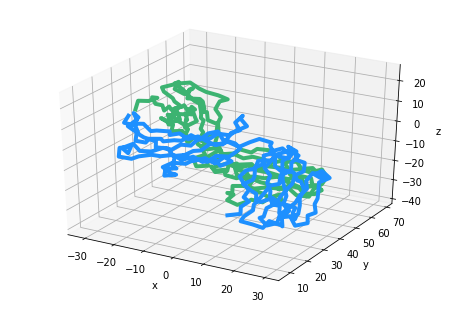

@> PDB file is found in the local folder (/Users/lacemaker/.../2osl.pdb.gz).
DEBUG:.prody:PDB file is found in the local folder (/Users/lacemaker/.../2osl.pdb.gz).
@> 7100 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:7100 atoms and 1 coordinate set(s) were parsed in 0.07s.


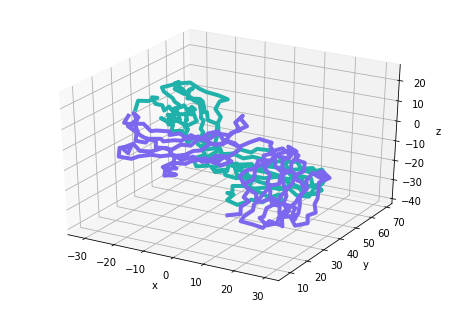

In [59]:
showPairInformation("2OSL", "L", "H")
showPairInformation("2OSL", "L", "H")

In [ ]:
prody.proteins.functions.showProtein(ref_selection);
# something is drawn, as you can see at the picture below:

In [ ]:
ref_selection.getResnums() # TODO: use this to make better picture